In [20]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter, gaussian_filter
import pickle

In [21]:
#print hele numpy arrayet
np.set_printoptions(threshold = np.inf)
np.set_printoptions(linewidth = np.inf)

In [22]:
def find_peaks(DB_spektogram, nabo_size=(20, 20), amplitude_threshold=-40):
    """
    Finder peaks i et dB spektrogram ved hjælp af lokalt maksimum
    (frekvens_bin, frame_index) blive retuneret
    """
    DB_smooth_spektogram = gaussian_filter(DB_spektogram, sigma=1.0) # lidt smoothing så små støj-peaks ikke dominier 
    #nabo_size angiver hvor stort et område af et fælt skal være størst i for at det bliver et peak
    lokale_maks = DB_smooth_spektogram == maximum_filter(DB_smooth_spektogram, size = nabo_size) # peaks før threshold
    peaks_over_threshold = np.argwhere(lokale_maks & (DB_smooth_spektogram > amplitude_threshold)) # peaks efter threshold
    
    return peaks_over_threshold

In [23]:
def lav_fingerprints(peaks, relationer_frem_i_tid=2, max_dt=100):
    """
    Danner simple fingerprints ud fra vores peaks
    Hver fingerprint er (f1, f2, dt, t1), hvor t1 er frame indekset for anker-peaket
    Antager at peaks er sorteret (efter tid tid) (kolonne 1)
    """
    fingerprints = []
    for i in range(len(peaks)): # laver et peaks loop
        frekvens_1, tid_1 = peaks[i] # vælg 1 anker peak

        for j in range(i + 1, i + relationer_frem_i_tid): # relater anker til andre punkter frem i tid for ikke at eksplodere i antal peaks
            
            if j >= len(peaks): # løbet tør for punkter -> stop med at kigge for dette anker
                break 

            frekvens_2, tid_2 = peaks[j]
            dt = tid_2 - tid_1 # tidsforskel

            if 0 < dt < max_dt: # gem fingerprint hvis inden for tids grænse
                fingerprints.append((int(frekvens_1), int(frekvens_2), int(dt), int(tid_1)))
                    
    return fingerprints


In [24]:
def opdel_peaks(peaks, frames_per_tidsvindue):
    """
    Deler peaks op i tidsvinduer, sådan at vi kan genkende kortere dele af sange istedet for at skulle bruge hele sange
    """
    segmenter = {} # kun et segment pr tidsvindue

    max_frame = peaks[:, 1].max() + 1 # find maks i tidskolonnen
    
    #løb gennem alle frames i hop af størelse "frames_per_tidsvindue"
    for segment_index, start_frame in enumerate(range(0, max_frame, frames_per_tidsvindue)): 
        slut_frame = start_frame + frames_per_tidsvindue # frame interval

        # udvælg alle peaks inde i viduet
        mask = (peaks[:, 1] >= start_frame) & (peaks[:, 1] < slut_frame) # peaks i dette vindue
        segment_af_peaks = peaks[mask].copy() 

        segment_af_peaks[:, 1] -= start_frame # forskyd tidspunkter så de starter ved 0, så alle segmenter matcher hinanden
        segmenter[segment_index] = segment_af_peaks 

    return segmenter


In [25]:
def sekunder_til_frames(sekunder, lydmålinger_pr_sekund, hop_længde):
    """
    Konverterer tid i sekunder til short-time-fourier-transform-frames.
    """
    return int(sekunder * lydmålinger_pr_sekund / hop_længde)


In [ ]:
# inspireret af (se Visualizing Peaks on the Spectrogram) https://www.scrapeless.com/en/blog/audio-fingerprinting
def plot_analyse(lyd_målinger, sr, DB, peaks, hop_længde, n_fft, filsti, navn):
    """
    Plotter waveform og spektrogram med peaks som blå gennemsigtige cirkler.
    """
    fig, ax = plt.subplots(2, 1, figsize=(12, 9), sharex=False) # lav plot med 2 sub figurer
    fig.suptitle(f"Analyse af: {navn} ({filsti.split('/')[-1]})", fontsize=14, weight='bold') #titel og fil navn uden mappe

    # plot 1 - Waveform (øverste plot  = ax[0])
    tid = np.linspace(0, len(lyd_målinger) / sr, num=len(lyd_målinger))
    ax[0].plot(tid, lyd_målinger)
    ax[0].set_title("Lydkurve (Waveform)")
    ax[0].set_ylabel("Amplitude")
    ax[0].set_xlabel("Tid (s)")

    # plot2  Spektrogram (nederste plot = ax[1])
    img = librosa.display.specshow(
        DB,
        sr=sr,
        hop_length=hop_længde,
        n_fft=n_fft,
        x_axis='time',
        y_axis='log', # logaritmisk scala
        cmap='magma',
        ax=ax[1]
    )

    fig.colorbar(img, ax=ax[1], format="%+2.0f dB")
    ax[1].set_title("Spektrogram (dB) med peaks")
    ax[1].set_xlabel("Tid (s)")

    # Overlay peaks som cyan farvet cirkler 
    abs_frames = peaks[:, 1]
    tider = librosa.frames_to_time(abs_frames, sr=sr, hop_length=hop_længde)
    frekvenser = librosa.fft_frequencies(sr=sr, n_fft=n_fft)[peaks[:, 0]]

    ax[1].scatter( #peaks som cirkler (punkt-plot)
        tider,
        frekvenser,
        s=25,
        facecolors='none',   # gennemsigtige cirkler
        edgecolors='cyan',   # blå kant
        linewidths=0.7,
        alpha=0.9,           # lidt gennemsigtigt
        label="Peaks"
    )
    ax[1].legend(loc='upper right') # markering af hvad de blå cirkler er

    plt.subplots_adjust(hspace=0.35)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [27]:
def behandl_sang(filsti,
                 navn,
                  plot=True,
                  n_fft=2048, # frekvens opløsning (kolonner i spektogram/frekvens spande)
                  hop_længde=512,  # afstand mellem vinduer
                  window_sekunder=1.0):
    """
    kører analysen for en sang 
    """

    #   Indlæs lyd  
    lyd_målinger, lydmålinger_pr_sekund = librosa.load(filsti, sr=None, mono=True)

    #   Spektrogram  
    D = np.abs(librosa.stft(lyd_målinger, n_fft=n_fft, hop_length=hop_længde))
    DB = librosa.amplitude_to_db(D, ref=np.max)

    print("Spektrogram størrelse", D.shape)
    #   Find peaks  
    peaks = find_peaks(DB)
    if peaks.size == 0:
        print("Ingen peaks fundet i: ", filsti, ". Returnerer tom segments-dict.")
        return {}

    # Sorter peaks efter tid
    peaks = peaks[peaks[:, 1].argsort()]

    #   Opdel peaks i segmenter  
    frames_per_window = sekunder_til_frames(window_sekunder, lydmålinger_pr_sekund, hop_længde)
    peak_segmenter = opdel_peaks(peaks, frames_per_window)
    
    #   Lav fingerprints for hvert segment  
    segments_fingerprints = {}
    step = frames_per_window
    for opdelings_index, opdelings_peaks in peak_segmenter.items(): # loop alle segmenter
        seg_fps = []

        if len(opdelings_peaks): # hvis der er peaks i segmentet så find deres fingerprints
            seg_fps = lav_fingerprints(opdelings_peaks)

        # Starttid i sekunder
        start_frame = opdelings_index * step
        segments_fingerprints[opdelings_index] = {
            "start_time_s": start_frame * hop_længde / lydmålinger_pr_sekund, #beregn tid 
            "fingerprints": seg_fps
        }

    #   Plot data hvis ønsket  
    if plot:
        plot_analyse(lyd_målinger, lydmålinger_pr_sekund, DB, peaks, hop_længde, n_fft, filsti, navn)

    return segments_fingerprints


Behandler clash royale intro sang...
Spektrogram størrelse (1025, 457)


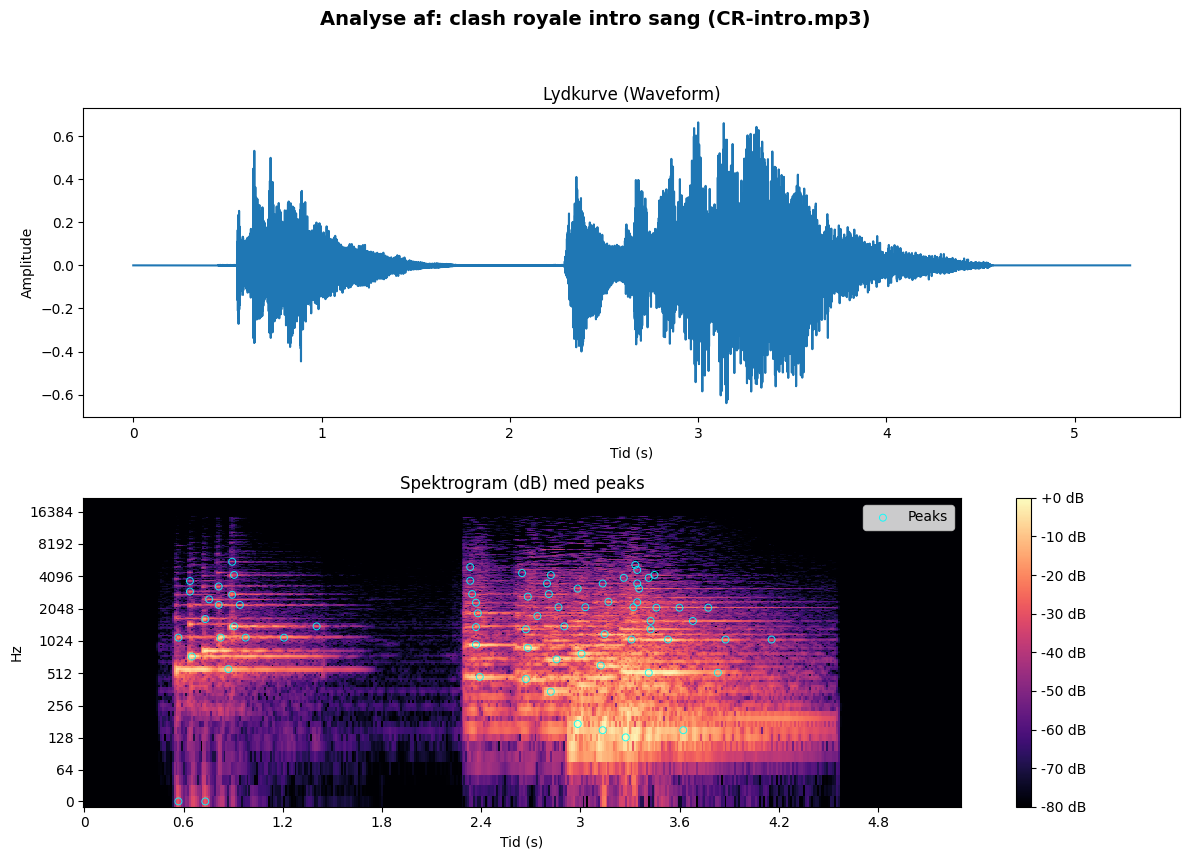

  Fundet 54 fingerprints fordelt på 1 segmenter

Behandler glad musik til børn...
Spektrogram størrelse (1025, 520)


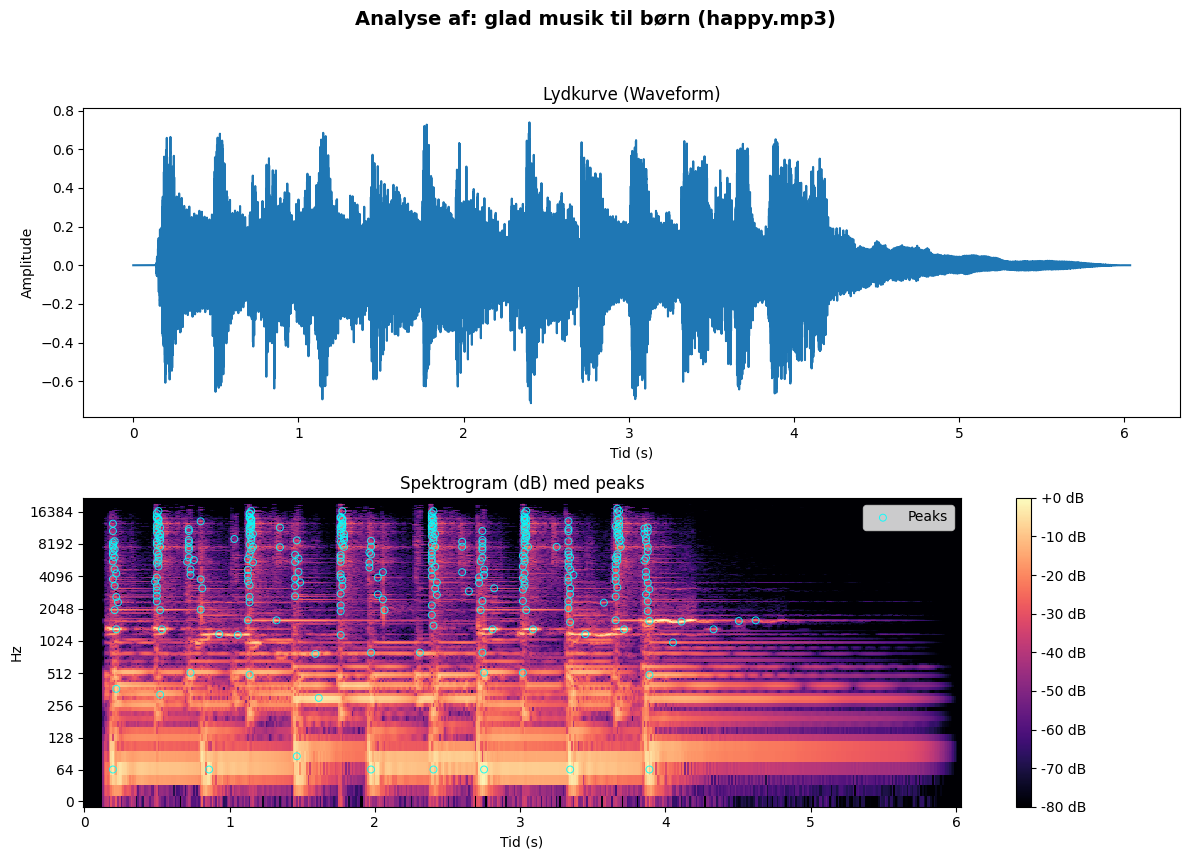

  Fundet 76 fingerprints fordelt på 1 segmenter

Behandler loft blæser...
Spektrogram størrelse (1025, 511)


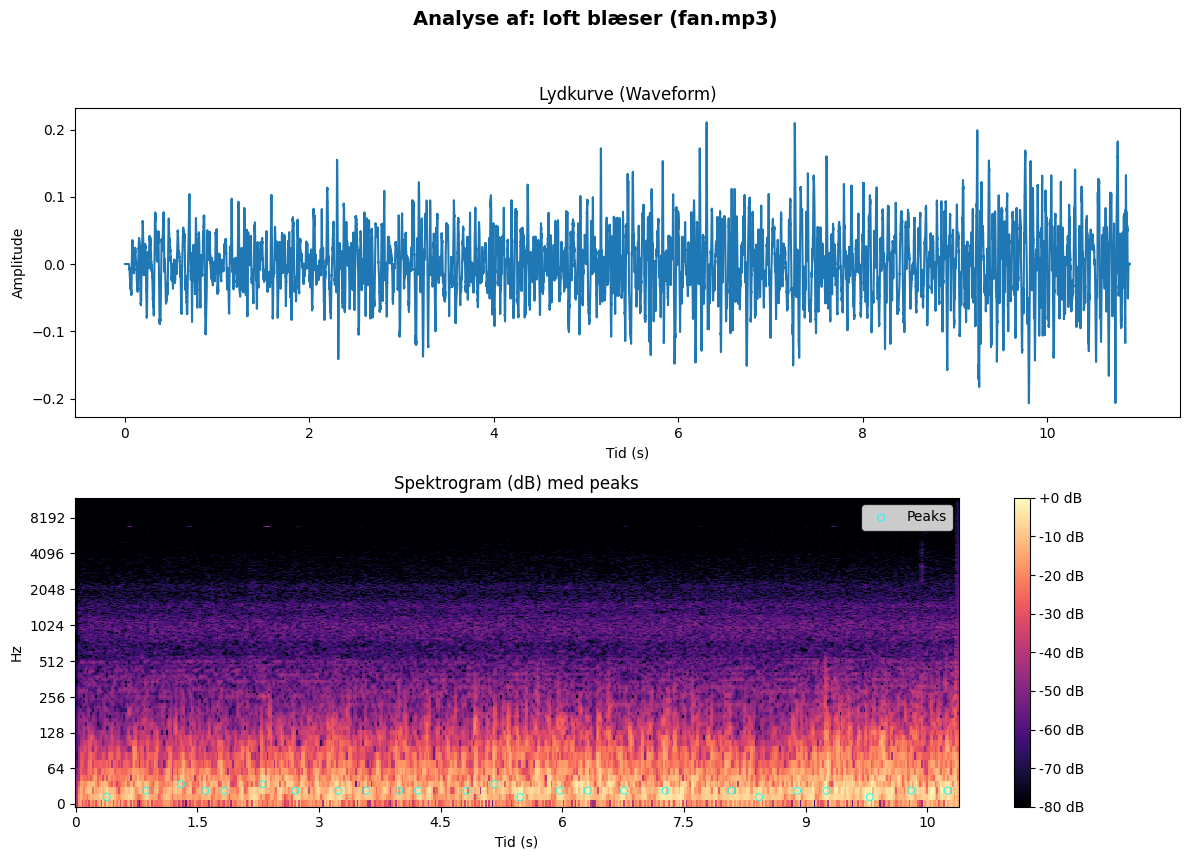

  Fundet 22 fingerprints fordelt på 3 segmenter

Behandler tunnel scream...
Spektrogram størrelse (1025, 131)


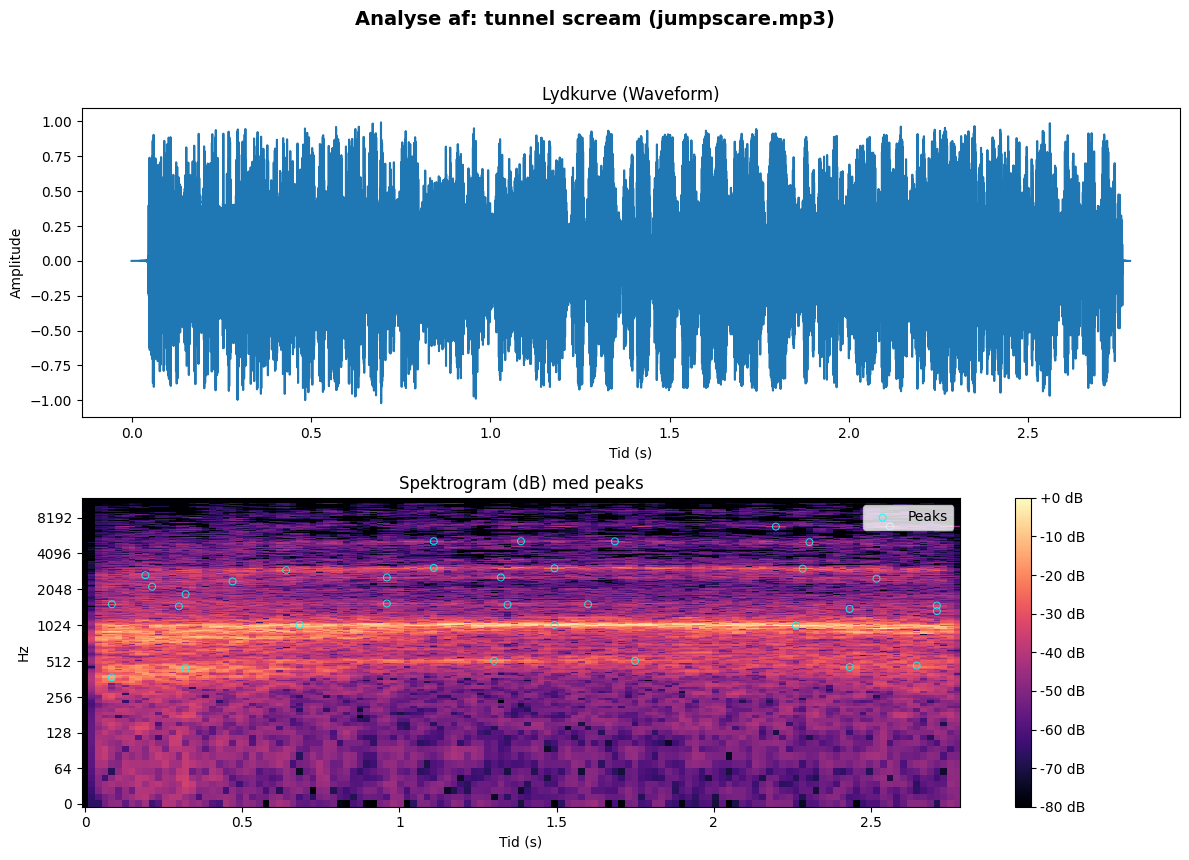

  Fundet 26 fingerprints fordelt på 1 segmenter

Behandler klaver...
Spektrogram størrelse (1025, 698)


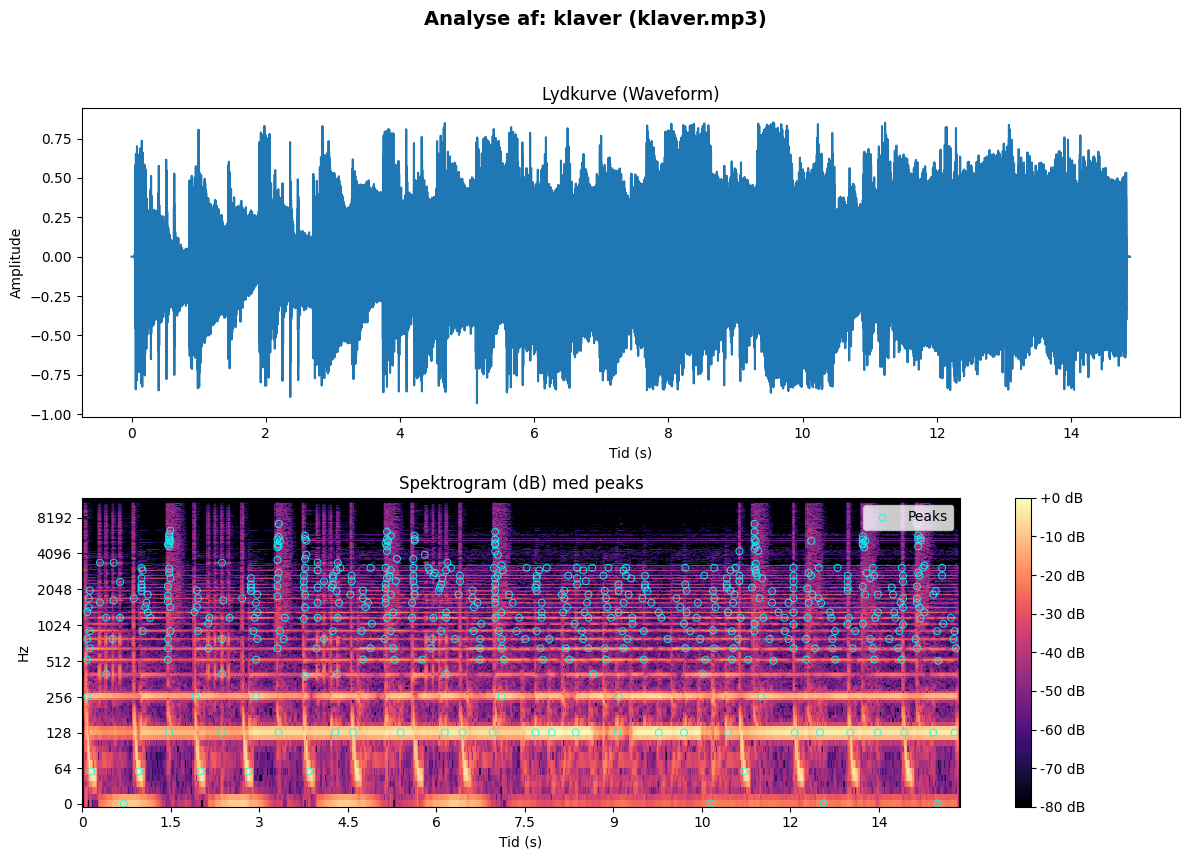

  Fundet 268 fingerprints fordelt på 3 segmenter

Behandler Lydoptagelse af mig der siger: Jeg hedder Jonas...
Spektrogram størrelse (1025, 255)


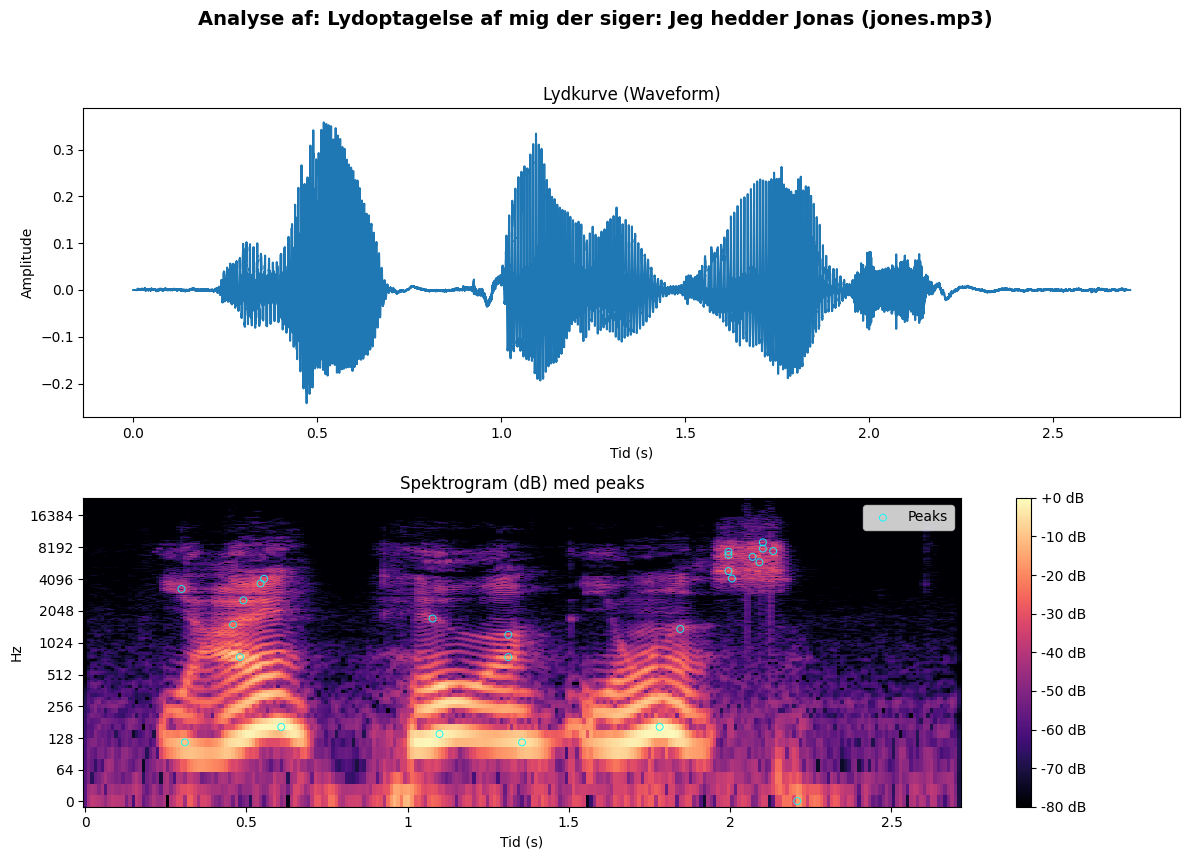

  Fundet 20 fingerprints fordelt på 1 segmenter

Behandler Billie Elish sang (watch)...
Spektrogram størrelse (1025, 18726)


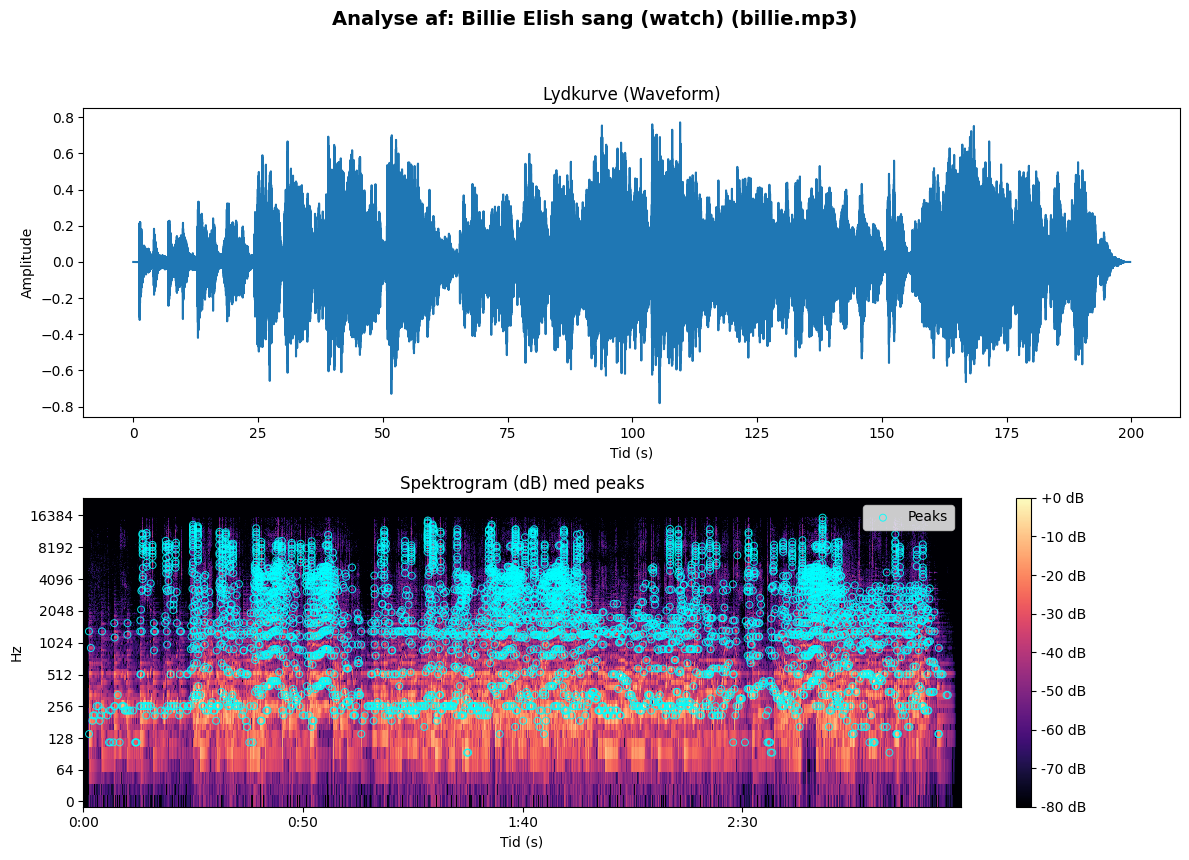

  Fundet 2921 fingerprints fordelt på 40 segmenter

Database-nøgler: ['clash royale intro sang', 'glad musik til børn', 'loft blæser', 'tunnel scream', 'klaver', 'Lydoptagelse af mig der siger: Jeg hedder Jonas', 'Billie Elish sang (watch)']
Database gemt som 'fingerprint_database_segmented.pkl'


In [28]:
#   Database til fingerprints for alle sange  
database = {}

# Filstierne til lydfilerne (opdater sti efter behov)
sange = {
    "clash royale intro sang": r"lyd/CR-intro.mp3",
    "glad musik til børn": r"lyd/happy.mp3",
    "loft blæser": r"lyd/fan.mp3",
    "tunnel scream": r"lyd/jumpscare.mp3",
    "klaver": r"lyd/klaver.mp3",
    "Lydoptagelse af mig der siger: Jeg hedder Jonas": r"lyd/jones.mp3",
    "Billie Elish sang (watch)": r"lyd/billie.mp3",
}

# Behandler hver sang
for navn, sti in sange.items():
    print(f"Behandler {navn}...")
    segments = behandl_sang(sti, navn, plot=True, window_sekunder=5.0)
    database[navn] = segments # gem segmenter i database (dictionary)
    total_fps = sum(len(v["fingerprints"]) for v in segments.values()) if segments else 0
    print(f"  Fundet {total_fps} fingerprints fordelt på {len(segments)} segmenter\n")

print("Database-nøgler:", list(database.keys()))
  
# Gem database
with open("fingerprint_database_segmented.pkl", "wb") as f:
    pickle.dump(database, f)

print("Database gemt som 'fingerprint_database_segmented.pkl'")

In [29]:
print("Database indhold: ")
for sang in database.keys():  
  print("Sang: ", sang, database[sang])


Database indhold: 
Sang:  clash royale intro sang {0: {'start_time_s': 0.0, 'fingerprints': [(51, 137, 6, 49), (172, 34, 1, 55), (34, 76, 7, 56), (0, 116, 2, 63), (116, 103, 5, 65), (153, 51, 1, 70), (51, 26, 4, 71), (26, 128, 2, 75), (260, 196, 1, 77), (65, 103, 3, 78), (103, 51, 3, 81), (51, 51, 20, 84), (51, 65, 17, 104), (65, 173, 80, 121), (232, 130, 1, 201), (130, 64, 2, 202), (108, 86, 1, 204), (86, 22, 1, 205), (22, 204, 22, 206), (204, 21, 2, 228), (61, 123, 1, 230), (41, 81, 5, 231), (81, 163, 5, 236), (163, 130, 1, 241), (130, 16, 1, 242), (195, 32, 3, 243), (32, 98, 1, 246), (98, 65, 3, 247), (65, 146, 7, 250), (8, 36, 2, 257), (36, 98, 2, 259), (98, 28, 8, 261), (28, 7, 1, 269), (163, 55, 1, 270), (55, 110, 2, 271), (110, 184, 8, 273), (184, 6, 1, 281), (6, 49, 3, 282), (49, 98, 1, 285), (98, 243, 1, 286), (243, 163, 1, 287), (218, 146, 1, 288), (146, 184, 5, 289), (24, 61, 1, 294), (73, 196, 2, 295), (196, 97, 1, 297), (97, 49, 6, 298), (49, 97, 6, 304), (97, 7, 2, 310), 